# Homework 3: Problems
## Due Wednesday 14 October, before class

### PHYS 440/540, Fall 2020
https://github.com/gtrichards/PHYS_440_540/


## Problem 1
On Data Camp:

Statistical Thinking in Python (Part 2): Bootstrap confidence intervals 

This is Chapter 2.  You shouldn't need Chapter 1, but you are welcome to do it.  If this chapter interests you, then you might get something out of completing Chapters 3 and 4 as well.


## Problem 2

Produce the "trace" plot for the clear/cloudy day problem from Inference2.ipynb.  Then plot the histogram of that trace, throwing away steps in the trace that could be considered part of the burn-in.  Your plots should look like the ones from class (or nicer!).  

* Do you get (essentially) the same answer for day $N$ as day $N+1$?
* Does it matter whether is was clear or cloudy on the day that you started? 
* What length "burn in" would you recommend for this process?

See starter code below.  You don't **have** to use it (e.g., if you have a different way to approach/code the problem), but it should help you get started.


## Problem 3

Copy over all the code cells from our interactive MCMC example in Inference2 (7 cells in all from the cell that imports numpy to the histogram of the chain).  

Change the code so that the likelihood plot is drawn in purple instead of green or red when the odds ratio for the next model is not favored, but is still larger than the random value used for the "accept" threshold.  So, now you will have green plots for steps that are both better and accepted, purple for steps that aren't better but are still accepted, and red for steps that are not accepted.  Also change the code so that the step size is small enough that you are likely to take a long time to reach the most likely value.

Once you have done both of those things, then:

* Run enough steps to show 2 steps that were accepted, even though they are worse.
* Plot the chain showing it taking some time to get from the initial value to oscillating around the most likely value.
* Plot a histogram of the chain both using the full chain and after throwing away the "burn" period.

0.8316
[0. 1. 1. ... 1. 1. 1.]


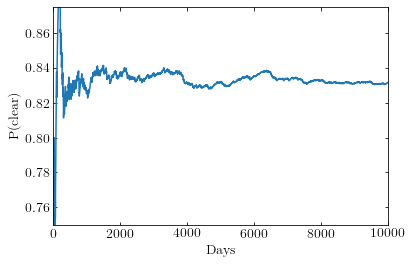

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
from scipy.stats import norm

N=10000 # Number of days to run the simulation
today = 0 # Set weather on the first day: clear=1 cloudy=0

tomorrow = 0 # Initialize tomorrow to some null value
cleardays = 0 # Keep track of the total number of clear days

chain = []
chain = np.array([])
pclearall = np.array([])
t = np.arange(N)

stop_burnin = 0

for idx in np.arange(N):

    if (today):
        cleardays += 1 #Increament the number of clear days if today was claer
    
    # Add value for today to our Markov Chain
    chain = np.append(chain,today)
    
    # Fraction of days that have been clear so far
    pclearall = np.append(pclearall,1.0*cleardays/(idx+1))
    
    #compare current average of pclearall to norm.mean()
#     if 1.0*cleardays/(idx+1) != norm.mean(pclearall):
#         stop_burnin += 1
    
    #Random number between 0 and 1 for tomorrow
    p = np.random.uniform(0,1)

    #clear today
    if (today == 1):
        if (p<=0.9):
            tomorrow = 1
        else:
            tomorrow = 0 
            
    #cloudy today
    else:
        if (p<=0.5):
            tomorrow = 0
        else:
            tomorrow = 1

    #Tomorrow will become today
    today=tomorrow
        

#Final value for fraction of clear days        
pclearfinal = 1.0*cleardays/N
print(pclearfinal)
print(chain)
        
plt.plot(t, pclearall)
plt.ylim(0.75, 0.875)
plt.xlim(0,N)

plt.xlabel('Days')
plt.ylabel('P(clear)')
plt.savefig('Chain.png')

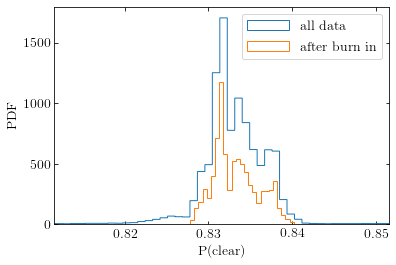

In [67]:
#now plot histogram (separated plots so I can pick burn in time based on above trace 
#without it resetting every run)

#plot PDF
plt.figure()
plt.xlabel('P(clear)')
plt.ylabel('PDF')
plt.xlim(pclearfinal-0.02, pclearfinal+0.02)
plt.ylim(0, 1800)


#plot all data
plt.hist(pclearall, bins=1000, label='all data', histtype='step')

#plot after burn in 
plt.hist(pclearall[1800:], bins=25, label='after burn in', histtype='step')

plt.legend()
plt.show()

---

Problem 3

In [68]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(123)

Text(0, 0.5, 'N')

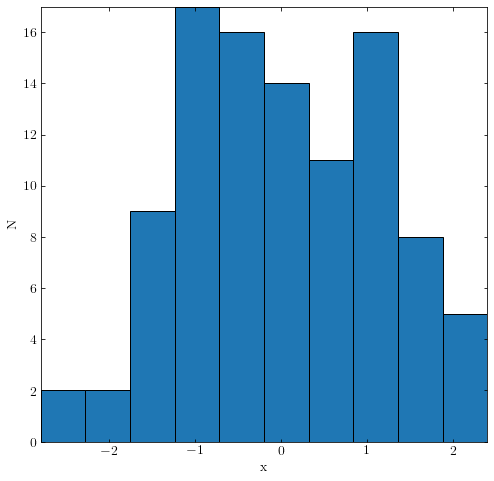

In [69]:
data = np.random.randn(100)
plt.figure(figsize=(8,8))
plt.hist(data)
plt.xlabel('x')
plt.ylabel('N')

Text(0, 0.5, 'post prob')

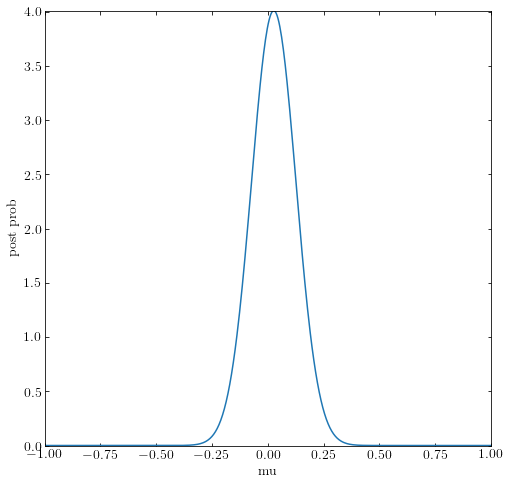

In [70]:
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    #Error-weighted sum of prior and average of data
    #Recall from lecture 3 the formula for the product of 2 Gaussians
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    # This is the Gaussian for the prior: mu_0 / sigma_0**2
    # This is the Gaussian for the likelihood: data.sum() / sigma**2
    # We are deriving the mean from the sum of the data values
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm.pdf(xgrid, mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,8))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post prob')

In [111]:
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        # changing the width of this distribution changes how big the jump is between trials.
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept>1 (since random limited to [0,1]) and if p_accept > rand as well
        #accept = np.random.rand() < p_accept
            
        #compare odds_ratio p_accept to rand and then to 3
        accept_threshold = np.random.rand()
        if p_accept > accept_threshold and p_accept >= 3: 
            color = 'g'
            accept = True
        elif p_accept > accept_threshold and p_accept < 3: 
            color='purple'
            accept = True
        else: 
            color='r'
            accept = False
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i, color)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i, color):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)
    #sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.hist(data,alpha=0.5,density='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid, mu_prior_mu, mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

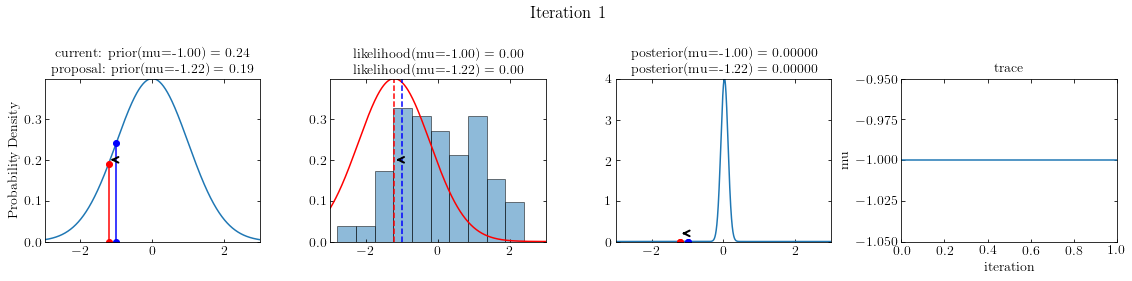

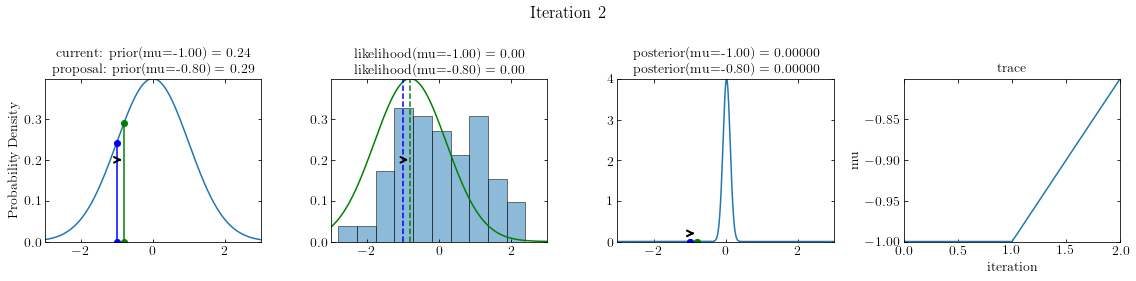

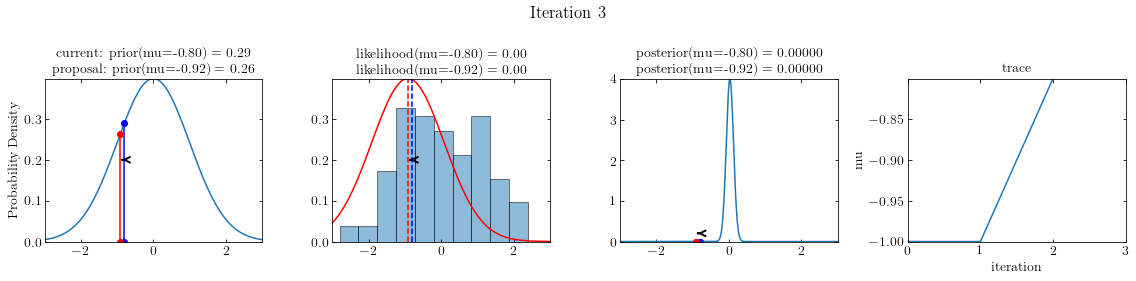

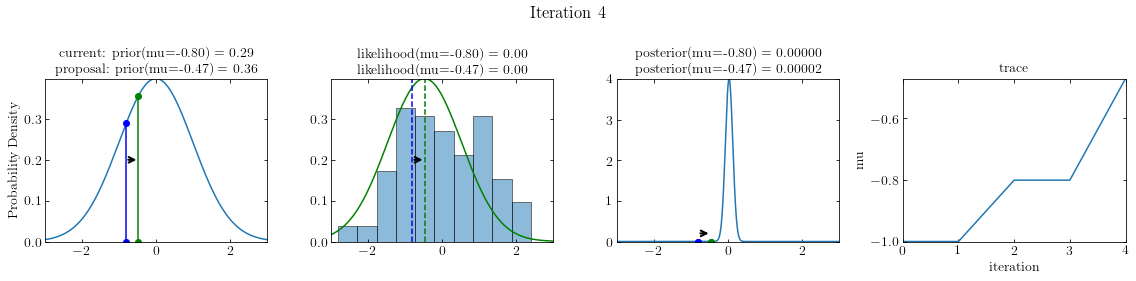

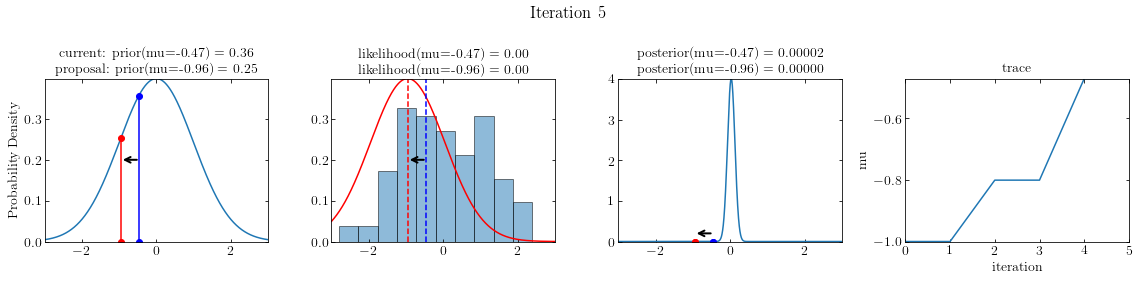

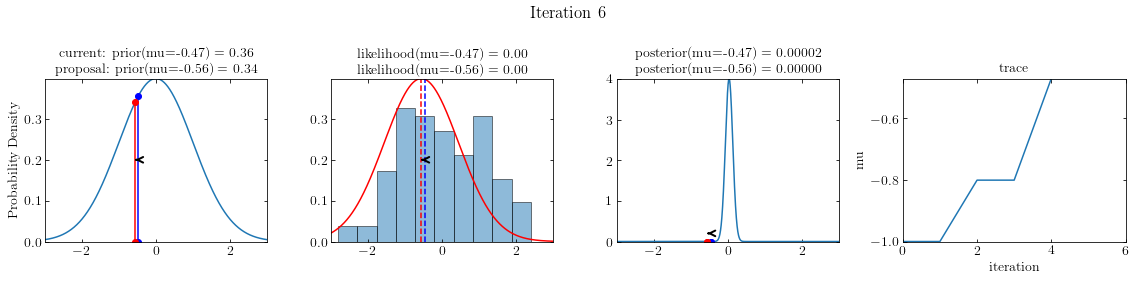

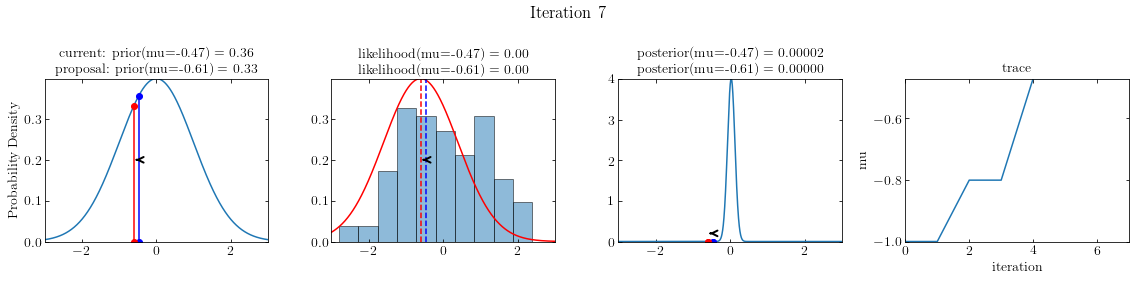

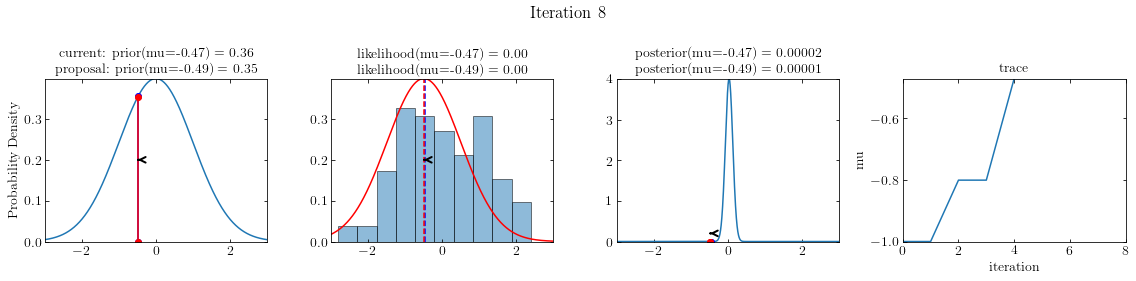

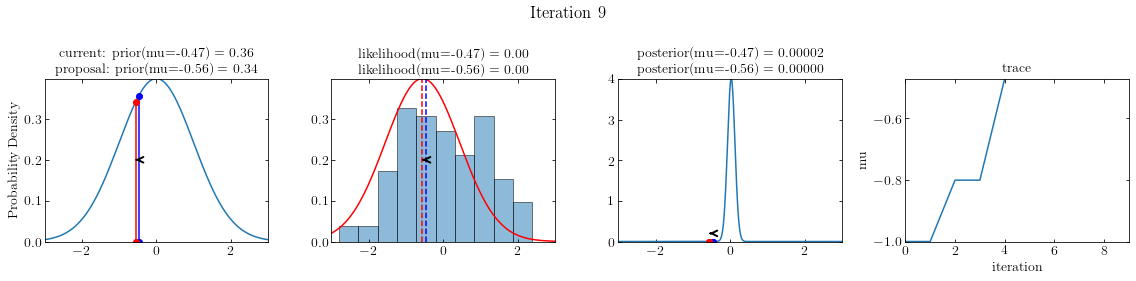

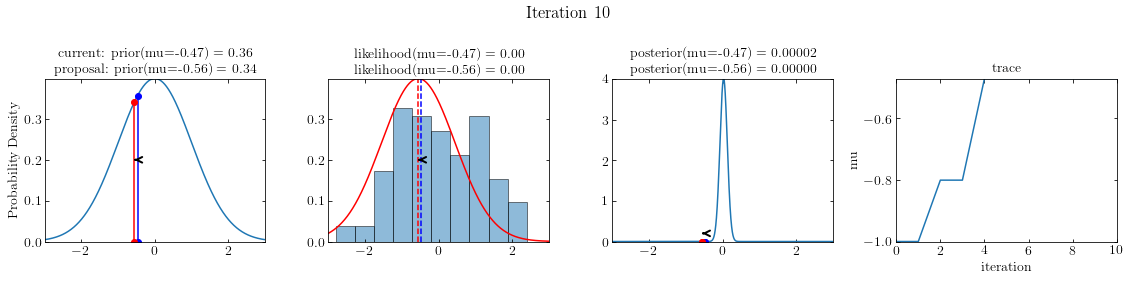

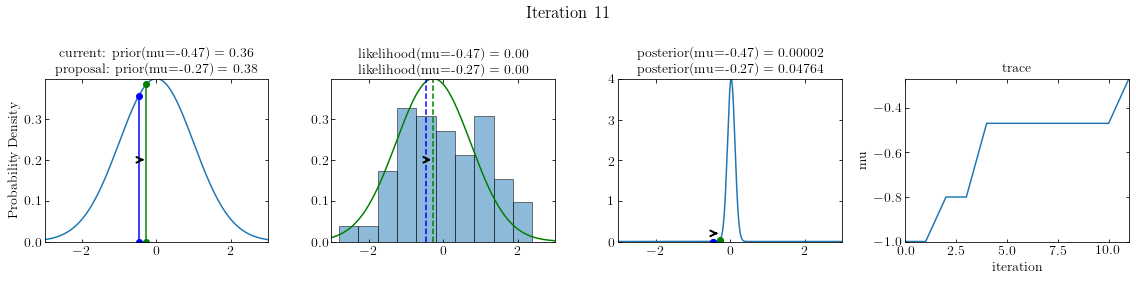

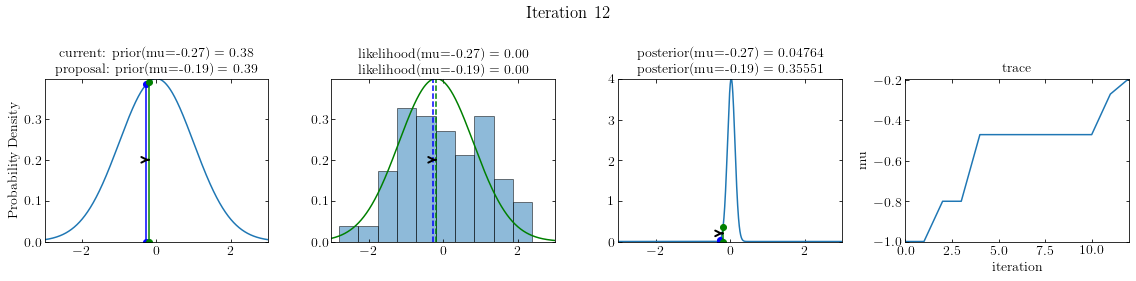

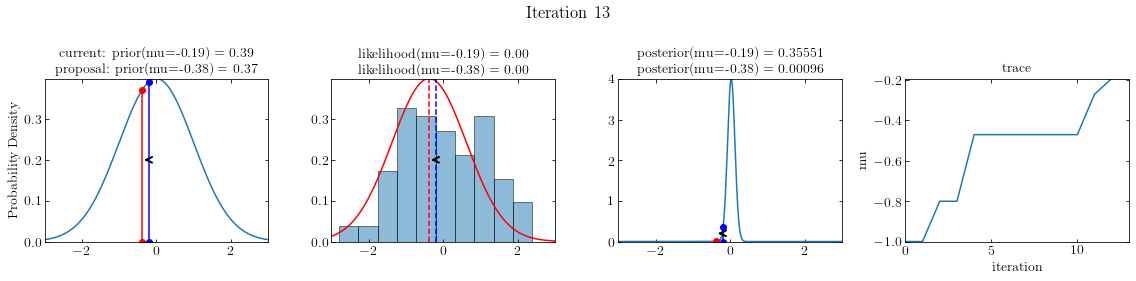

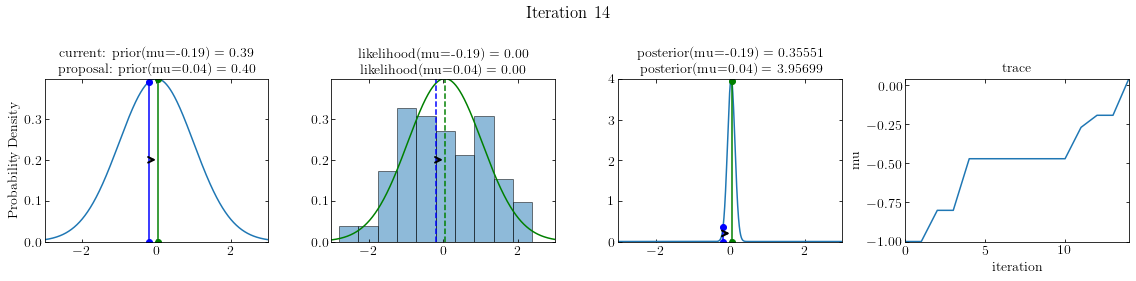

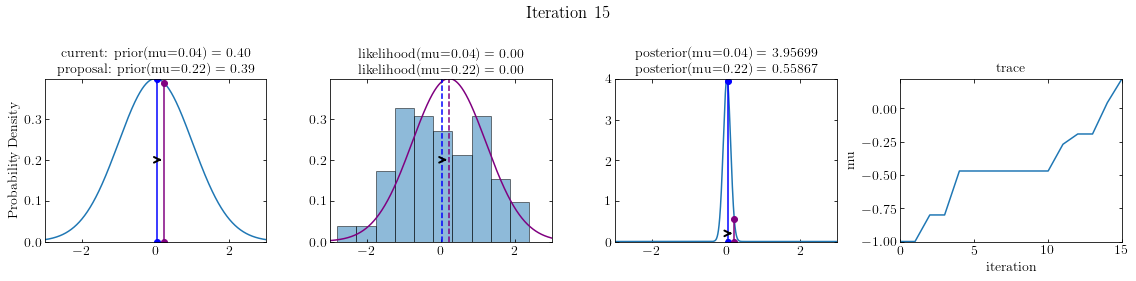

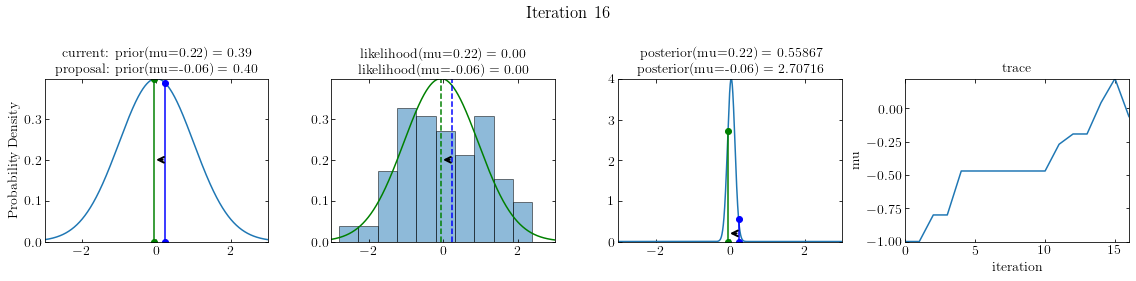

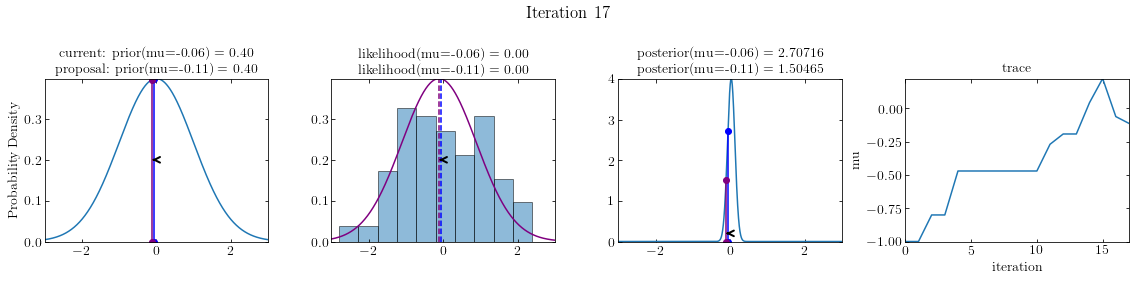

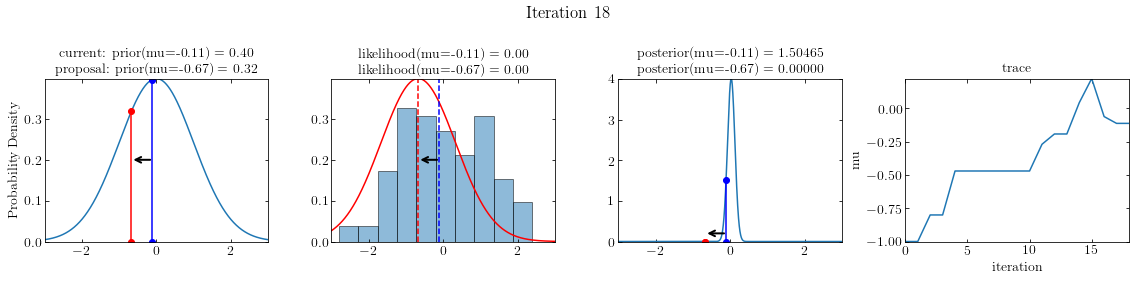

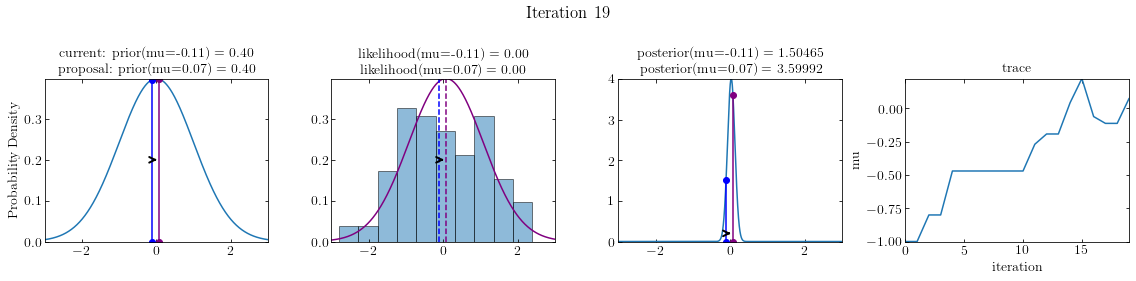

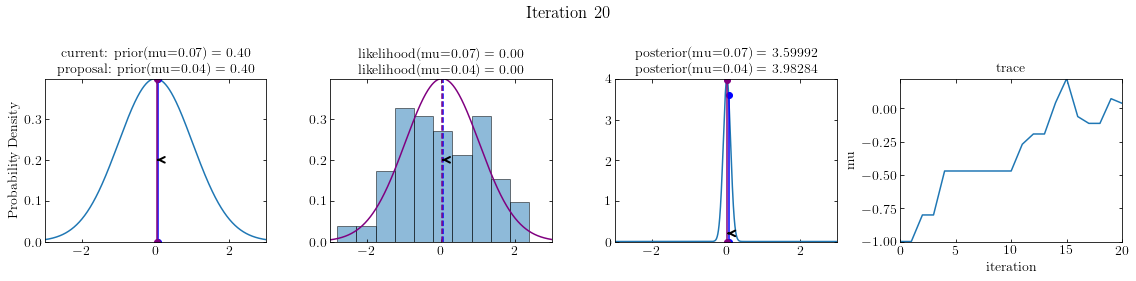

In [115]:
np.random.seed(123)
sampler(data, samples=20, mu_init=-1., proposal_width=0.2, plot=True);

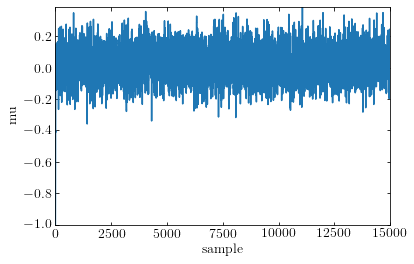

In [117]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.2)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

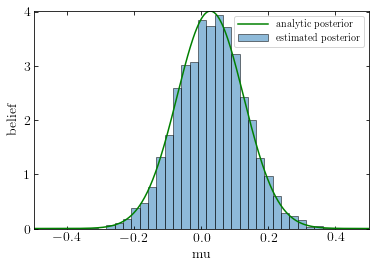

In [118]:
ax = plt.subplot()

ax.hist(posterior[500:],bins=30,alpha=0.5,density='True',label='estimated posterior')
xplot = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, xplot, 0, 1)
ax.plot(xplot, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend(fontsize=10);

---
### Grade: 2/3.5
- Prob #2: Answer to questions? (-0.5)
- Prob #3: No burn-in phase, use smaller proposal width; need histogram for both before/after burn-in (-1)